## Setup

In [242]:
import os
import configparser

import pandas as pd
import requests
import geopandas as gpd
from shapely.geometry import Point, Polygon

import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

In [2]:
#set filepaths
project_root = os.path.abspath(os.getcwd())
root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
config_file =  os.path.join(root, "config.cfg")

# geodata for shapefiles
config = configparser.ConfigParser()
config.read(config_file)
gdata_root = config["geodata"]["path"]

In [227]:
#fonts
from matplotlib import font_manager

#font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
title_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Inter-Bold.ttf')
subtitle_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Inter-SemiBold.otf')
label_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Inter-Regular.ttf')

## Load data

In [3]:
# Read shapefile and reproject to coordinate system
london_all = gpd.GeoDataFrame.from_file(os.path.join(gdata_root, "london-shapefiles\\London_Borough_Excluding_MHW.shp"))
_crs = "EPSG:32630"
london_all = london_all.to_crs(_crs)

#join london boroughs into one gdf for plotting later
london = gpd.GeoDataFrame({'geometry': london_all.unary_union,'index':[0]}, crs=_crs)

In [18]:
# london population estimates
pop = pd.read_excel("ukpopestimatesmid2021on2021geographyfinal.xls", sheet_name="MYE2 - Persons", skiprows=7)
pop = pop[pop["Geography"]=="London Borough"][["Code", "Name", "All ages"]]

# merge with london shapefile
london_all = pd.merge(london_all, pop, left_on="GSS_CODE", right_on="Code", how="left")

In [4]:
# get premade fishnet grids for london
grid2km = gpd.GeoDataFrame.from_file(os.path.join(gdata_root, "fishnets\\london-2000-2000.geojson"))
grid1km = gpd.GeoDataFrame.from_file(os.path.join(gdata_root, "fishnets\\london-1000-1000.geojson"))

In [151]:
# Request data from OSM

#get data from OSM using Overpass API
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area[name="Greater London"][admin_level=5]->.searchArea;

(node["leisure"="sports_centre"](area.searchArea); 
way["leisure"="sports_centre"](area.searchArea);
rel["leisure"="sports_centre"](area.searchArea);
node["leisure"="fitness_centre"](area.searchArea); 
way["leisure"="fitness_centre"](area.searchArea);
rel["leisure"="fitness_centre"](area.searchArea);
node["leisure"="pitch"](area.searchArea); 
way["leisure"="pitch"](area.searchArea);
rel["leisure"="pitch"](area.searchArea);
node["leisure"="golf_course"](area.searchArea); 
way["leisure"="golf_course"](area.searchArea);
rel["leisure"="golf_course"](area.searchArea);
);
out center;
"""
response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()

In [153]:
#convert json into dataframe
df_dict = {"id":[], "type": [], "lat":[], "lon": [],"name":[], "leisure":[], "sport":[], "surface":[]}

for element in data['elements']:
    df_dict["id"].append(element["id"])
    df_dict["type"].append(element["type"])
    
    for tag in list(df_dict.keys())[4:]:
        try:
            df_dict[tag].append(element["tags"][tag])
        except KeyError:
            df_dict[tag].append("") 
    if element["type"]=="node":
        df_dict["lat"].append(element["lat"])
        df_dict["lon"].append(element["lon"])
    else:
        df_dict["lat"].append(element["center"]["lat"])
        df_dict["lon"].append(element["center"]["lon"])
        
df = pd.DataFrame.from_dict(df_dict)

# convert into geodataframe
geometry = [Point(xy) for xy in zip(df['lon'].astype(float), df['lat'].astype(float))]
gdf = gpd.GeoDataFrame(df, crs = 'EPSG:4326', geometry = geometry)

In [169]:
gdf.loc[gdf["leisure"]=="golf_course", "sport"] = "golf"
gdf.loc[(gdf["leisure"]=="fitness_centre"), "sport"] = "fitness"

# Visualisation

## By borough

### Soccer or Tennis or Basketball?

In [170]:
#merge data and boroughs
gdf = gdf.to_crs(london_all.crs)
_filter = (gdf["leisure"].isin(["pitch", "fitness_centre"]))
borough_merged = gpd.sjoin(gdf[_filter], london_all, how='left')

In [171]:
# count venues by cell
dissolve = borough_merged.groupby(["index_right", "sport"])["id"].count().to_frame().unstack()
dissolve.columns = dissolve.columns.droplevel(level=0)
dissolve["total"] = dissolve.sum(axis=1)

In [172]:
data_to_plot = london_all.copy()

# include counts
data_to_plot.loc[dissolve.index, "total_venues"] = dissolve["total"].values
data_to_plot["venues_per_1000"] = data_to_plot["total_venues"]/data_to_plot["All ages"] *1000
for _type in ["tennis", "soccer", "basketball", "fitness"]:
    data_to_plot.loc[dissolve.index, _type] = dissolve[_type].values
    data_to_plot.loc[dissolve.index, _type + "_per_1000"] = dissolve[_type].values/data_to_plot["All ages"] *1000

In [140]:
from palettable.cartocolors.sequential import BluGrn_7, Emrld_7, agGrnYl_7_r, BluYl_7, BurgYl_7, Sunset_7

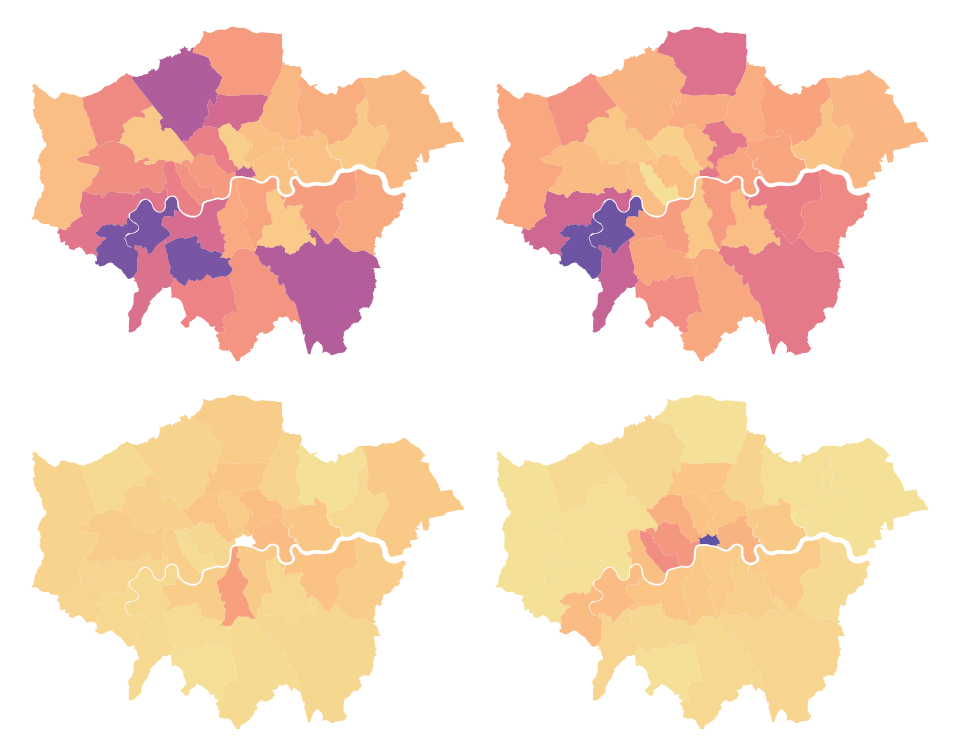

In [173]:
#setup figure and grida
cmap = Sunset_7.mpl_colormap

fig, axs = plt.subplot_mosaic([['tennis', 'soccer'],['basketball', 'fitness']], figsize=(10, 8))
plt.subplots_adjust(left=0.01, bottom=0.03, right=0.99, top=0.95, wspace=-0.1, hspace=0.)    

data_to_plot.plot(ax=axs["tennis"], column=data_to_plot['tennis_per_1000'], cmap=cmap, vmin=0, vmax=0.65)
data_to_plot.plot(ax=axs["soccer"], column=data_to_plot['soccer_per_1000'], cmap=cmap, vmin=0, vmax=0.65)
data_to_plot.plot(ax=axs["basketball"], column=data_to_plot['basketball_per_1000'], cmap=cmap, vmin=0, vmax=0.65)
data_to_plot.plot(ax=axs["fitness"], column=data_to_plot['fitness_per_1000'], cmap=cmap, vmin=0, vmax=0.65)
for ax in axs:
    axs[ax].axis("off")

### Fitness centres

In [177]:
#merge data and boroughs
gdf = gdf.to_crs(london_all.crs)
_filter = (gdf["leisure"]=="fitness_centre")| ((gdf["leisure"]=="sports_centre") & (gdf["sport"]=="fitness"))
borough_merged = gpd.sjoin(gdf[_filter], london_all, how='left')

# count venues by cell
dissolve = borough_merged.groupby(["index_right", "sport"])["id"].count().to_frame().unstack()
dissolve.columns = dissolve.columns.droplevel(level=0)
dissolve["total"] = dissolve.sum(axis=1)

# include counts
data_to_plot = london_all.copy()
data_to_plot.loc[dissolve.index, "total_venues"] = dissolve["total"].values
data_to_plot["venues_per_1000"] = data_to_plot["total_venues"]/data_to_plot["All ages"] *1000
data_to_plot.loc[data_to_plot["Code"]=="E09000001", "venues_per_1000"] = None

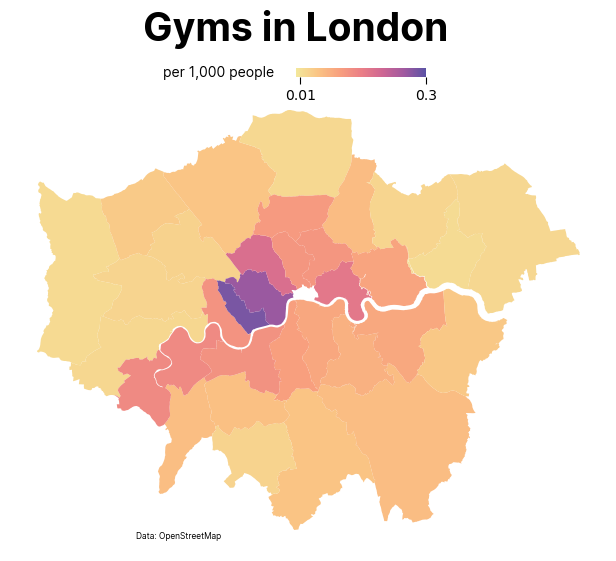

In [246]:
# setup
cmap = Sunset_7.mpl_colormap
fig, ax = plt.subplots( figsize=(10, 6))

# plot data
data_to_plot.plot(ax=ax, column=data_to_plot['venues_per_1000'], cmap=cmap, vmin=0, vmax=0.3)

# format axis
ax.axis("off")

# legend
lgd = fig.add_axes([0.5, 0.9, 0.13, 0.015]) #axes to hold colorbar
cmappable = ScalarMappable(norm=Normalize(0,0.3), cmap=cmap)              
cb = plt.colorbar(cmappable, cax=lgd, anchor=(1,1.2), orientation='horizontal', drawedges=False, ticks=[0.01,0.3])
cb.set_ticklabels(["0.01", "0.3"])
cb.outline.set_visible(False)
lgd.tick_params(size=5)
lgd.text(-0.05, 0, "per 1,000 people", ha="right", size=10, linespacing=1.5,fontproperties=label_font,)

# ===
#title
plt.figtext(0.5, 0.96 , "Gyms in London", fontproperties=title_font, fontsize=28,  ha="center", color="black")
plt.figtext(0.34, 0.13 , "Data: OpenStreetMap", fontproperties=label_font, fontsize=6,  ha="left",
           color="black")


plt.savefig("gyms_in_london.png", bbox_inches='tight', dpi=300, pad_inches=0.45)
plt.show()

In [124]:
_filter= (gdf["leisure"]=="sports_centre") & (gdf["sport"]=="fitness")
gdf[_filter]
#& (gdf["sport"]=="soccer")

,id,type,lat,lon,name,leisure,sport,surface,geometry
54,931615210,node,51.543938,-0.151637,Mosaic,sports_centre,fitness,,POINT (697504.123 5714161.448)
61,1141415201,node,51.519728,-0.085068,Slim Jim's,sports_centre,fitness,,POINT (702226.445 5711651.737)
94,1787108615,node,51.514732,-0.085371,Bank Health Club,sports_centre,fitness,,POINT (702227.514 5711095.336)
98,1968366424,node,51.453356,-0.101841,,sports_centre,fitness,,POINT (701355.342 5704226.123)
110,2124626806,node,51.374102,-0.103507,Lion's Pride MMA,sports_centre,fitness,,POINT (701588.050 5695410.121)
149,2793892926,node,51.513267,-0.084890,Matt Roberts,sports_centre,fitness,,POINT (702267.429 5710933.787)
164,3113203931,node,51.462029,-0.173115,Milo and the Bull,sports_centre,fitness,,POINT (696367.064 5704996.788)
165,3118263525,node,51.516885,-0.076444,Ignite PT,sports_centre,fitness,,POINT (702837.239 5711359.428)
167,3164383488,node,51.515532,-0.079915,1Rebel,sports_centre,fitness,,POINT (702602.453 5711199.390)
174,3251204027,node,51.648709,-0.051382,Anytime Fitness,sports_centre,fitness,,POINT (703984.181 5726085.647)


## Fishnet

In [74]:
#filter
_filter = (gdf["leisure"]=="pitch") & (gdf["sport"]=="soccer")

#merge data and grid
grid = grid2km.copy()
gdf = gdf.to_crs(grid.crs)

merged = gpd.sjoin(gdf[_filter], grid, how='left')

In [75]:
# count venues by cell
dissolve = merged.groupby(["index_right"])["id"].count().to_frame()

# include counts and type in grid
grid.loc[dissolve.index, "total_fitness"] = dissolve["id"]

#dissolve.index

(669921.5265748396, 735921.5265748396, 5683342.325711634, 5733942.325711634)

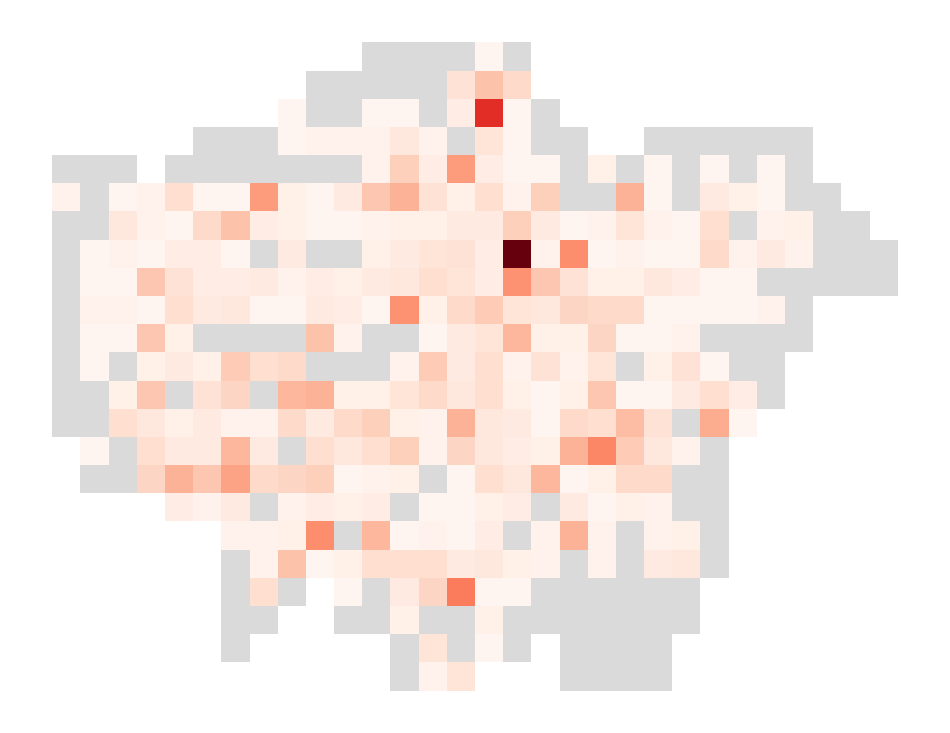

In [76]:
#plot
fig, ax = plt.subplots(figsize=(12, 10))
#fig.set_facecolor(bg_color)

# ===
# Data
values = "total_fitness"
grid.plot(ax=ax, column=values, alpha=1, zorder=3, cmap="Reds")
grid.plot(ax=ax, color="#DADADA",zorder=2)
ax.axis("off")